# Acknowledgements:

Code is adapted from the fantastic SIR dynamics simulation designed by Alison Hill, available on GitHub here: https://github.com/alsnhll/SIRNestedNetwork

The reference paper is [here](https://www.nature.com/articles/s41591-020-1104-0#Abs1); I would highly recommend you read it!

In [36]:
!pip install jax
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install --upgrade scipy networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# imports for simulations
import jax.numpy as np
import numpy as np2
from jax import random, vmap, pmap, jit
from jax.lax import fori_loop
from jax.nn import relu

import functools
import matplotlib.pyplot as plt
from matplotlib import colors
import time
import tqdm

import collections
import numpy as np2
import random as random2
import networkx as nx
import scipy.stats as ss
import scipy.sparse as sparse
import math
from itertools import combinations
import pandas as pd
import itertools
%matplotlib inline

In [39]:
plt.rcParams['pdf.fonttype'] = 42

# Defining the 3 layer network


## Defining functions


In [40]:
# Create fully connected groups for household
def create_house_neighbourhoods(pop, dist_groups, neighbourhood_size, percent_external):
    """ Divide the population into households depending upon their distribution of sizes and then constructing neighbourhoods
    @param pop : Total size of the population
    @type : int
    @param dist_groups : Dist of sizes of households in the population
    @type : list
    @return : Adjacency matrix of household and neighbourhood layers
    @type : 2D array
    """
    matrix_household = np2.zeros((pop,pop))
    matrix_neighbourhood = np2.zeros((pop,pop))
    matrix_external = np2.zeros((pop,pop))

    external_connections = []
    neighbourhood_size = neighbourhood_size
    neighbourhood_tracker = []
    counter = 0
    indices = np2.arange(0,pop,1)
    no_households = len(dist_groups)
    no_external = int(neighbourhood_size*percent_external/100)
    
    for indx, size in enumerate(dist_groups):
        # Create household
        house = indices[:int(size)]
        comb = list(itertools.combinations(house,2))
        for i,j in comb:
            matrix_household[i][j] = 1
            matrix_household[j][i] = 1
        neighbourhood_tracker.extend(house)
        counter += size
        
        # Create neighbourhood if neighbourhood size is reached
        if counter >= neighbourhood_size or indx == no_households-1:
            external_connections.extend(np2.random.choice(neighbourhood_tracker,size=no_external,replace=False))
            comb = list(itertools.combinations(neighbourhood_tracker,2))
            for i,j in comb:
                matrix_neighbourhood[i][j] = 1
                matrix_neighbourhood[j][i] = 1
            neighbourhood_tracker = []
            counter = 0
        indices = [i for i in indices if i not in house]
    
    # Add external connections
    comb = list(itertools.combinations(external_connections,2))
    for i,j in comb:
        matrix_external[i][j] = 1
        matrix_external[j][i] = 1
    return np2.sign(matrix_household), np2.sign(matrix_neighbourhood - matrix_household), np2.maximum(matrix_external-matrix_neighbourhood,0)

In [41]:
# Create external connections
def create_external(pop,degree_dist):
    """ Create random external connections
    @param pop : Total population size
    @type : int
    @param degree_dist : Degree distribution for this layer
    @type : list
    @return : Adjacency matrix 
    @type : 2D array
    """
    # Create external stubs that are randomly connected 
    matrix = np2.zeros((pop,pop))
    external_stubs = []
    
    for i in range(pop):
        stubs = degree_dist[i]
        external_stubs.extend([i for j in range(stubs)])
      
    # Attach the random stubs        
    external_pairs = np2.random.choice(external_stubs, size = (int(len(external_stubs)/2),2), replace = False)
    for pairs in range(len(external_pairs)):
        i = external_pairs[pairs][0]
        j = external_pairs[pairs][1] 
        matrix[i][j] = 1
        matrix[j][i] = 1

    return np2.sign(matrix)

## Inputs
### Population size

In [42]:
pop = 1000

### Households

In [43]:
# % Household sizes in China from 2010. 

one_house = 13.66
two_house = 24.37
three_house = 26.86
four_house = 17.56
five_house = 16.66
total_house = one_house + two_house + three_house + four_house + five_house

house_size_dist = np2.array([one_house,two_house,three_house,four_house,five_house])/total_house

# House-hold sizes
household_sizes = []
pop_house = 0

while pop_house <= pop:
    size = np2.random.choice(np.arange(1,6,1),p=house_size_dist,size=1)
    household_sizes.append(size)
    pop_house += size

household_sizes[-1] -= pop_house-pop

# Mean of household degree dist 
mean_household = sum((np2.asarray(household_sizes)-1)*np2.asarray(household_sizes))/pop
print(mean_household)

[2.532]


### Neighbourhoods

In [44]:
neighbourhood_size = 100
perc_neighbourhood_external=10

### Create households and neighbourhoods and external connections. Only 10% of people from each neighborhood are fully connected externally.

In [45]:
matrix_household, matrix_neighbourhood, matrix_external = create_house_neighbourhoods(pop,household_sizes,neighbourhood_size,perc_neighbourhood_external)

# Stochastic simulation

In [46]:
def simulate_seir(w, total_steps, exposed_len_sampler, infection_len_sampler, resistance_len_sampler,
                 init_e, init_i, init_r, key=0, epoch_len=1):
  """Simulates microscopic SEIRS dynamics on a weighted, directed graph.

  The simulation is Markov chain, whose state is recorded by three device arrays,
  e, i, and r. The jth entry of e indicates the remaining time steps the invididual
  will be non-infective. The jth entry of i indicates the remaining time steps that 
  individual j will say infected (time until recovery). The jth entry of r indicates 
  the remaining time steps that individual j is immune to infection (time until
  loss off immunity)
  
  Args:
    w: A DeviceArray of shape [n, n], where n is the population size. The entry
      ij represents the probability that individual i infects j.
    total_steps: The total number of updates to the Markov chain.
    exposed_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains exposed.
    infection_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains infected.
    resistence_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains resistant.
    init_e: A DeviceArray of shape [n] containing ints for the initial state of
      exposed individuals for the simulation. It records the number of time 
      steps the individual will remain incubating, but not infectious.
    init_i: A DeviceArray of shape [n] containing ints for the initial state of
      infected individuals for the simulation. It records the number of time 
      steps the individual will remain infected.
    init_r: A DeviceArray of shape [n] containing ints for the initial state of
      recovered individuals for the simulation. It records the number of time 
      steps the individual will remain immune.
    key: An int to use as the PRNGKey.
    epoch_len: The number of steps that are JIT'ed in the computation. After
      each epoch the current state of the Markov chain is logged.
    
  Returns:
    The final states of e, i, and r, and a list containing the history of the Markov
    chain.
  """
  n = w.shape[0]
  key = random.PRNGKey(key)

  @jit
  def interaction_sampler(key, w):
    key, subkey = random.split(key)
    keys = random.split(subkey, n**2)
    keys = np.reshape(keys, [n, n, 2])

    return key, vmap(vmap(lambda k, p: random.bernoulli(k, p)))(keys, w)
  
  @jit
  def interaction_step(key, e, i, r):
    key, interaction_sample = interaction_sampler(key, w)
    bool_i = np.sign(i)
    bool_e = np.sign(e)
    bool_r = np.sign(r)
    new_exposed = (1-bool_r) * (1-bool_e) * (1-bool_i) * np.sign(
        bool_i @ interaction_sample)
    key, exposed_lens = exposed_len_sampler(key)
    return (key, e + new_exposed * exposed_lens, i, r)    
    
    
  @jit
  def clearing_step(key, e, i, r):
    newly_infected = e == 1
    key, infection_lens = infection_len_sampler(key)
    i = i + newly_infected * infection_lens

    newly_recovered = i == 1
    key, resistance_lens = resistance_len_sampler(key)
    r = r + newly_recovered * resistance_lens
    return (key, relu(e-1), relu(i-1), relu(r-1))

  def eval_fn(t, e, i, r, history):
    # print('i({}): {}'.format(t, np.mean(np.sign(i))))
    # print('r({}): {}'.format(t, np.mean(np.sign(r))))
    history.append([np.mean(np.sign(e)), np.mean(np.sign(i)), np.mean(np.sign(r))])
    return history

  @jit
  def step(t, args):
    return clearing_step(*interaction_step(*args))
  
  e = init_e
  i = init_i
  r = init_r

  epochs = int(total_steps // epoch_len)
  history = []
  for epoch in tqdm.tqdm(range(epochs), total=epochs, position=0):
    key, e, i, r = fori_loop(0, epoch_len, step, (key, e, i, r))
    history = eval_fn(epoch*epoch_len, e, i, r, history)
  return e, i, r, history

In [47]:
# Define geometric distributions for exponential waiting time sampling
def geometric(key, p, shape=()):
  shape_ = shape
  if shape_ == ():
    try:
      shape_ = p.shape
    except:
      shape_ = ()
  return _geometric(key, p, shape_)

@functools.partial(jit, static_argnums=(2,))
def _geometric(key, p, shape):
  u = random.uniform(key, shape=shape)
  return np.where(u <= p, np.zeros(shape, dtype=np.int32), np.ceil(
      np.log(1. - u) / np.log(1. - p) - .1).astype(np.int32))

## Defining parameters for exponentially distributed times

In [48]:
Tmax = 300 # Stop time of simulation
n = pop # Population size

avg_incubation = 4.
sigma = 1/avg_incubation

avg_infection = 10. 
gamma = 1/avg_infection

avg_immunity = 100.
xi = 1/avg_immunity

delta_t = 0.1 # timestep 
total_steps = int(Tmax / delta_t) # total timesteps to run simulation
tvec=np2.arange(0,Tmax,delta_t)

mean_incubation_len = avg_incubation / delta_t
mean_infection_len = avg_infection / delta_t
mean_immunity_len = avg_immunity / delta_t

init_num_inf=1 #Initial number of ppl infected
beta=0.24
infect_prob=beta*delta_t

In [49]:
# Vector of distribution of duration of incubation for each individual
# Fixed duration
@jit
def exposed_len_sampler(key): 
  key, subkey = random.split(key)
  return key, 1 + geometric(subkey, p=1./mean_incubation_len, shape=(n,))


# Vector of distribution of infection lengths for each individual. 
# Exponentially distributed waiting times
@jit 
def infection_len_sampler(key):
  #return key, int(mean_infection_len) * np.ones([n])
  key, subkey = random.split(key)
  return key, 1 + geometric(subkey, p=1./mean_infection_len, shape=(n,))


# Vector of distribution of duration of immunity for each individual
# Fixed duration
@jit
def resistance_len_sampler(key): 
  key, subkey = random.split(key)
  return key, 1 + geometric(subkey, p=1./mean_immunity_len, shape=(n,))
  # return key, 2**20 * np.ones([n]) – For SEIR model

# Results

In [50]:
# Visualizes a network color-coded by population compartments
def gen_network(e, i, r, w):
  G = nx.from_numpy_matrix((w))
  values = []
  for j in range(len(r)):
      if r[j] > 0:
          values.append('teal') #Blue
      elif i[j] > 0:
          values.append('chartreuse')
      elif e[j] > 0:
          values.append('tab:orange')
      else:
          values.append('w') #White

  plt.figure(figsize=(10,8))
  pos = nx.spring_layout(G)
  nx.draw_networkx_nodes(G, pos, node_size=20, node_color=values, alpha=.8)
  nx.draw_networkx_edges(G, pos, alpha=0.1)
  plt.axis('off')
  plt.scatter(3, 3, color='lightgray', alpha=.8, label='Susceptible')
  plt.scatter(3, 3, color='tab:orange', alpha=.8, label='Exposed')
  plt.scatter(3, 3, color='chartreuse', alpha=.8, label='Infected')
  plt.scatter(3, 3, color='teal', alpha=.8, label='Recovered')
  plt.xlim([-1, 1])
  plt.ylim([-1, 1])
  plt.legend(fontsize=10)
  plt.title('Network Structure for SEIRS Dynamics', fontsize=14)
  plt.show()
  return;

## Without intervention

### Crowded
neighborhood = 100, pop = 1000, iterations = 10

In [51]:
# Define adjacency matrix
# Weights of the connections per layer
w_house = 1
w_neighbourhood = 0.01
w_external= 1e-3
adjacency_matrix = (w_house*matrix_household) + (w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external)
mean_degree = sum(sum(adjacency_matrix))/pop
w = infect_prob * adjacency_matrix # Contact network multiplied by infection rate

In [52]:
soln_i = []
soln_r = []
soln_e = []

init_num_inf = 3

number_trials = 10

for key in range(number_trials):

  #Initial condition
  _, init_e = infection_len_sampler(random.PRNGKey(key+100))
  init_ind = np.int32(random.uniform(random.PRNGKey(key), shape=(init_num_inf,), maxval=n))
  init_state=np.zeros(n)
  init_state=init_state.at[init_ind].set(np.squeeze(np.ones(init_num_inf)))
  init_e = init_e*init_state
  init_i = np.zeros([n])
  init_r = np.zeros([n])

  #Run simulation
  e, i, r, history = simulate_seir(
      w, total_steps, exposed_len_sampler, infection_len_sampler, resistance_len_sampler, 
      init_e, init_i, init_r, epoch_len=1, key=key)
  soln = np.array(history)
  soln_e.append(soln[:,0])
  soln_i.append(soln[:,1])
  soln_r.append(soln[:,2])

100%|██████████| 3000/3000 [00:07<00:00, 392.37it/s]


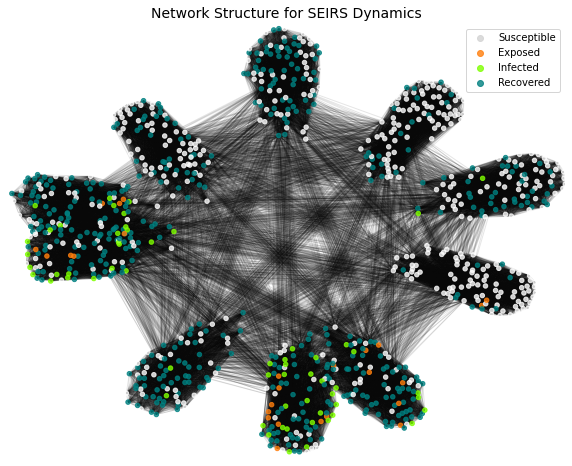

In [53]:
gen_network(e, i, r, w)

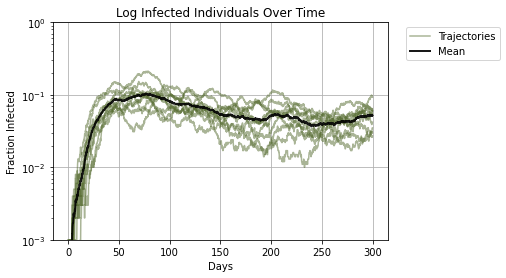

In [54]:
mean_traj = sum(soln_i)/number_trials
for i in range(number_trials-1):
  plt.plot(tvec, soln_i[i], color='darkolivegreen', alpha=.5)
plt.plot(tvec, soln_i[-1], color='darkolivegreen', alpha=.5, label='Trajectories')
plt.plot(tvec, mean_traj, color='k', alpha=.9, lw=2, label='Mean')
plt.xlabel('Days')
plt.ylabel('Fraction Infected')
plt.ylim([1/pop, 1])
plt.semilogy()
plt.grid(':')
plt.title('Log Infected Individuals Over Time')
plt.legend(bbox_to_anchor=[1.35, 1]);

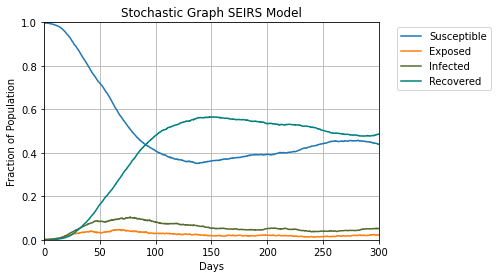

In [55]:
mean_e = sum(soln_e)/number_trials
mean_i = sum(soln_i)/number_trials
mean_r = sum(soln_r)/number_trials
mean_s = 1 - mean_e-mean_i-mean_r

plt.plot(tvec, mean_s, color='tab:blue', label='Susceptible')
plt.plot(tvec, mean_e, color='tab:orange', label='Exposed')
plt.plot(tvec, mean_i, color='darkolivegreen', label='Infected')
plt.plot(tvec, mean_r, color='teal', label='Recovered')
plt.title('Stochastic Graph SEIRS Model')
plt.xlim([0, 300])
plt.ylim([0, 1])
plt.xlabel('Days')
plt.ylabel('Fraction of Population')

plt.grid(':')
plt.legend(bbox_to_anchor=[1.35, 1]);

## With intervention

Same intervention given to both populations, but post-intervention there will be more residual connections in the more crowded population, allowing continual spread. Intervention efficacy = 40%

### Code

In [56]:
def simulate_intervention(
    ws, step_intervals, exposed_len_sampler, infection_len_sampler, resistance_len_sampler,
    init_e, init_i, init_r, key=0, epoch_len=1):
  """Simulates microscopic SEIRS dynamics on a weighted, directed graph.

  The simulation is Markov chain, whose state is recorded by three device arrays,
  e, i, and r. The jth entry of e indicates the remainig time steps that individual 
  j will remaing incubating, but not infective. The jth entry of i indicates the 
  remaining time steps that individual j will stay infected. The jth entry of r 
  indicates the remaining time steps that individual j is resistant to infection.
  
  Args:
    ws: A list of DeviceArrays of shape [m, n, n], where m is
      the number of distinct structures and n is the population size.
      The dynamics will be simulated on each structure sequentially.
    step_intervals: A list of ints indicating the number fo simulation steps
      performed on each population strucutre.
    exposed_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains exposed.
    infection_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains infected.
    resistence_len_sampler: A function taking a PRNGKey that returns a
      DeviceArray of shape [n]. Each entry is an iid sample from the distibution
      specifying the amount of time that the individual remains resistant.
    init_e: A DeviceArray of shape [n] containing ints for the initial state of
      exposed for the simulation. It records the number of time steps the 
      individual will remain incubating.
    init_i: A DeviceArray of shape [n] containing ints for the initial state of
      infected for the simulation. It records the number of time steps the 
      individual will remain infected.
    init_r: A DeviceArray of shape [n] containing ints for the initial state of
      resistant for the simulation. It records the number of time steps the 
      individual will remain resistant.
    key: An int to use as the PRNGKey.
    epoch_len: The number of steps that are JIT'ed in the computation. After
      each epoch the current state of the Markov chain is logged.
    
  Returns:
    The final states of e, i, and r, and a list containing the history of the Markov
    chain.
  """

  history = []
  e, i, r = init_e, init_i, init_r
  for t, (w, total_steps) in enumerate(zip(ws, step_intervals)):
    e, i, r, history_ = simulate_seir(
        w, total_steps, exposed_len_sampler, infection_len_sampler, resistance_len_sampler,
        e, i, r, key=key, epoch_len=1)
    history.extend(history_)
    print('Completed interval {} of {}'.format(t+1, len(ws)))

  return e, i, r, history

### Crowded


In [63]:
# Define adjacency matrix
# Weights of the connections per layer
w_house = 1
w_neighbourhood = 0.01
w_external= 1e-2
adjacency_matrix = (w_house*matrix_household) + (w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external)
mean_degree = sum(sum(adjacency_matrix))/pop

# post intervention
npi=.4 # Efficacy of intervention
adjacency_matrix_npi = (w_house*matrix_household) + ((w_neighbourhood*matrix_neighbourhood) + (w_external*matrix_external))*(1-npi)

In [64]:
Tmax = 300 # total time to run simulation for
n = pop # Population size

avg_incubation = 4.
sigma = 1/avg_incubation

avg_infection = 10. 
gamma = 1/avg_infection

avg_immunity = 100.
xi = 1/avg_immunity

delta_t = 0.1 # timestep 

Tint=0
Lint=300

days_list = [Tint, Lint]
days = sum(days_list)
step_intervals = [int(days / delta_t) for days in days_list]
total_steps = sum(step_intervals)
tvec=np2.arange(0,Tint+Lint,delta_t)

mean_incubation_len = avg_incubation / delta_t
mean_infection_len = avg_infection / delta_t 
mean_immunity_len = avg_immunity / delta_t

init_num_inf=1 # Initial number of ppl infected
beta=0.24
infect_prob=beta*delta_t

w1 = infect_prob * adjacency_matrix # Contact network multiplied by infection rate

w2 = infect_prob * adjacency_matrix_npi

ws = [w1, w2]

In [65]:
soln_i = []
soln_r = []
soln_e = []

init_num_inf = 3

number_trials = 10

for key in range(number_trials):

  #Initial condition
  _, init_e = infection_len_sampler(random.PRNGKey(key+100))
  init_ind = np.int32(random.uniform(random.PRNGKey(key), shape=(init_num_inf,), maxval=n))
  init_state=np.zeros(n)
  init_state=init_state.at[init_ind].set(np.squeeze(np.ones(init_num_inf)))
  init_e = init_e*init_state
  init_i = np.zeros([n])
  init_r = np.zeros([n])

  #Run simulation
  e, i, r, history = simulate_intervention(
      ws, step_intervals, exposed_len_sampler, infection_len_sampler, resistance_len_sampler, 
      init_e, init_i, init_r, epoch_len=1, key=key)
  soln = np.array(history)
  soln_e.append(soln[:,0])
  soln_i.append(soln[:,1])
  soln_r.append(soln[:,2])

0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:10<00:00, 293.55it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 388.92it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 394.90it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 394.37it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 395.53it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 400.08it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:08<00:00, 354.43it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 397.69it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 391.00it/s]


Completed interval 2 of 2


0it [00:00, ?it/s]


Completed interval 1 of 2


100%|██████████| 3000/3000 [00:07<00:00, 385.79it/s]


Completed interval 2 of 2


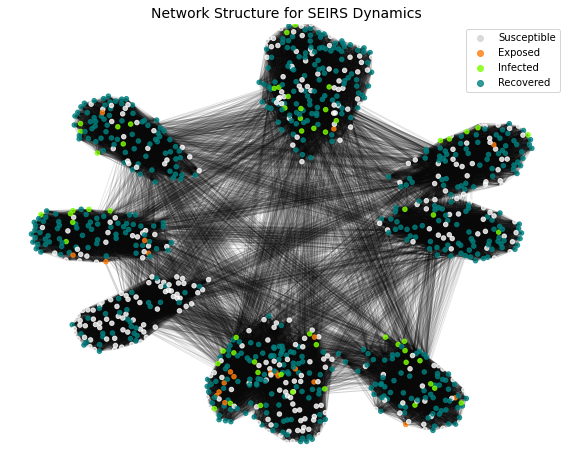

In [66]:
gen_network(e, i, r, w)

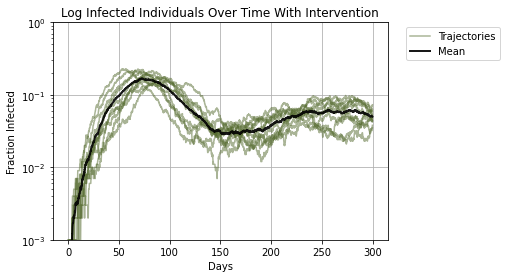

In [67]:
mean_traj = sum(soln_i)/number_trials
for i in range(number_trials-1):
  plt.plot(tvec, soln_i[i], color='darkolivegreen', alpha=.5)
plt.plot(tvec, soln_i[-1], color='darkolivegreen', alpha=.5, label='Trajectories')
plt.plot(tvec, mean_traj, color='k', alpha=.9, lw=2, label='Mean')
plt.xlabel('Days')
plt.ylabel('Fraction Infected')
plt.ylim([1/pop, 1])
plt.semilogy()
plt.grid(':')
plt.title('Log Infected Individuals Over Time With Intervention')
plt.legend(bbox_to_anchor=[1.35, 1]);

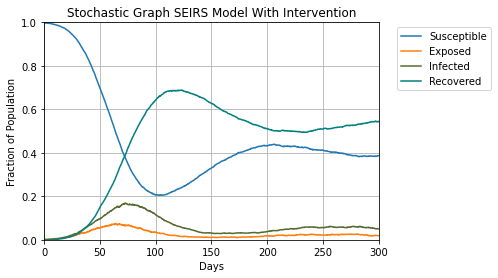

In [68]:
mean_e = sum(soln_e)/number_trials
mean_i = sum(soln_i)/number_trials
mean_r = sum(soln_r)/number_trials
mean_s = 1 - mean_e-mean_i-mean_r

plt.plot(tvec, mean_s, color='tab:blue', label='Susceptible')
plt.plot(tvec, mean_e, color='tab:orange', label='Exposed')
plt.plot(tvec, mean_i, color='darkolivegreen', label='Infected')
plt.plot(tvec, mean_r, color='teal', label='Recovered')
plt.title('Stochastic Graph SEIRS Model With Intervention')
plt.xlim([0, 300])
plt.ylim([0, 1])
plt.xlabel('Days')
plt.ylabel('Fraction of Population')

plt.grid(':')
plt.legend(bbox_to_anchor=[1.35, 1]);